In [12]:
import os

os.environ['OPENAI_API_KEY']='...'

In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [2]:
!pip install openai langchain tiktoken pdfplumber llama_index pypdf

  Obtaining dependency information for urllib3<2 from https://files.pythonhosted.org/packages/48/fe/a5c6cc46e9fe9171d7ecf0f33ee7aae14642f8d74baa7af4d7840f9358be/urllib3-1.26.17-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.4/143.4 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.6
    Uninstalling urllib3-2.0.6:
      Successfully uninstalled urllib3-2.0.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
types-requests 2.31.0.8 requires urllib3>=2, but you have urllib3 1.26.17 which is incompatible.


# Knowledge graph query engine

https://siwei.io/graph-enabled-llama-index/knowledge_graph_query_engine.html



## Logging

In [13]:
import logging
import sys

logging.basicConfig(stream=sys.stdout, level=logging.DEBUG) ###<----this will display a LOT of stuff, put INFO if want less
logging.getLogger().addHandler(logging.StreamHandler(stream=sys.stdout))

## Setting Up the llama_index service context

In [15]:
from llama_index import (
    KnowledgeGraphIndex,
    LLMPredictor,
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.storage.storage_context import StorageContext
from llama_index.graph_stores import NebulaGraphStore

from langchain.chat_models import ChatOpenAI
from IPython.display import Markdown, display

llm_predictor = LLMPredictor(llm=ChatOpenAI(temperature=0, model_name="gpt-4"))
service_context = ServiceContext.from_defaults(llm_predictor=llm_predictor, chunk_size=512)

## Prepare for NebulaGraph  

Before next step to creating the Knowledge Graph, let's ensure we have a running NebulaGraph with defined data schema.

In [3]:
%pip install ipython-ngql nebula3-python


Note: you may need to restart the kernel to use updated packages.


In [16]:
# Create a NebulaGraph cluster with:
    # Option 0 for machines with Docker: `curl -fsSL nebula-up.siwei.io/install.sh | bash`
    # Option 1 for Desktop: NebulaGraph Docker Extension https://hub.docker.com/extensions/weygu/nebulagraph-dd-ext

# Once the nebula Graph cluster is installed, execute the following in the nebula graph console:
#(1)
    # CREATE SPACE llamaindex(vid_type=FIXED_STRING(256), partition_num=1, replica_factor=1);
#(2) Select create space and run the following to define your schema
    # USE llamaindex;
    # CREATE TAG entity(name string);
    # CREATE EDGE relationship(relationship string);
    # CREATE TAG INDEX entity_index ON entity(name(256));

## ---> please input the correct values for nebula graphs, these are the default values for localhost

import os
os.environ['NEBULA_USER'] = "root"
os.environ['NEBULA_PASSWORD'] = "nebula" # default is "nebula
os.environ['NEBULA_ADDRESS'] = "192.168.1.198:9669" # assumed we have NebulaGraph installed locally

space_name = "llamaindex"
edge_types, rel_prop_names = ["relationship"], ["relationship"] # default, could be omit if create from an empty kg
tags = ["entity"] # default, could be omit if create from an empty kg

Prepare for StorageContext with graph_store as NebulaGraphStore

In [17]:
graph_store = NebulaGraphStore(space_name=space_name, edge_types=edge_types, rel_prop_names=rel_prop_names, tags=tags)
storage_context = StorageContext.from_defaults(graph_store=graph_store)

## Build the Knowledge Graph with LlamaIndex  
With the help of Llama Index and LLM defined, we could build Knowledge Graph from given documents.

If we have a Knowledge Graph on NebulaGraphStore already, this step could be skipped

### Step 1, load data from Wikipedia for "Guardians of the Galaxy Vol. 3"

In [7]:
from llama_index import download_loader

WikipediaReader = download_loader("WikipediaReader")

loader = WikipediaReader()

guardian_docs = loader.load_data(pages=['Guardians of the Galaxy Vol. 3'], auto_suggest=False)

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): en.wikipedia.org:80
Starting new HTTP connection (1): en.wikipedia.org:80
DEBUG:urllib3.connectionpool:http://en.wikipedia.org:80 "GET /w/api.php?prop=info%7Cpageprops&inprop=url&ppprop=disambiguation&redirects=&titles=Guardians+of+the+Galaxy+Vol.+3&format=json&action=query HTTP/1.1" 301 0
http://en.wikipedia.org:80 "GET /w/api.php?prop=info%7Cpageprops&inprop=url&ppprop=disambiguation&redirects=&titles=Guardians+of+the+Galaxy+Vol.+3&format=json&action=query HTTP/1.1" 301 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): en.wikipedia.org:443
Starting new HTTPS connection (1): en.wikipedia.org:443
DEBUG:urllib3.connectionpool:https://en.wikipedia.org:443 "GET /w/api.php?prop=info%7Cpageprops&inprop=url&ppprop=disambiguation&redirects=&titles=Guardians+of+the+Galaxy+Vol.+3&format=json&action=query HTTP/1.1" 200 538
https://en.wikipedia.org:443 "GET /w/api.php?prop=info%7Cpageprops&inprop=url&ppprop=disambiguat

In [8]:
!pip install arxiv

  Obtaining dependency information for arxiv from https://files.pythonhosted.org/packages/f0/06/9b9d553d93e25ae27ec5ba794216afb1af248e43d85a35e922a85cbb396a/arxiv-1.4.8-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6048 sha256=e5d88fdf7812753a9d236eda9a8223ff75086ecd920251b36b1e194bc73799a4
  Stored in directory: /home/vscode/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


In [9]:
import arxiv

paper = next(arxiv.Search(id_list=['2303.11366']).results())
paper.download_pdf(filename='agent-reflexion.pdf')

INFO:arxiv.arxiv:Requesting 100 results at offset 0
Requesting 100 results at offset 0
INFO:arxiv.arxiv:Requesting page of results
Requesting page of results
INFO:arxiv.arxiv:Got first page; 1 of inf results available
Got first page; 1 of inf results available


'./agent-reflexion.pdf'

In [18]:
from llama_index import SimpleDirectoryReader

documents = SimpleDirectoryReader("../../datatest2").load_data()  #on local

DEBUG:llama_index.readers.file.base:> [SimpleDirectoryReader] Total files added: 1
> [SimpleDirectoryReader] Total files added: 1
> [SimpleDirectoryReader] Total files added: 1
LLAMINDEX Input file: ../../datatest2/agent-reflexion.pdf
PDF reader opening file  ../../datatest2/agent-reflexion.pdf


In [19]:
len(documents)

18

### Step 2, Generate a KnowledgeGraphIndex with NebulaGraph as graph_store

Then, we will create a KnowledgeGraphIndex to enable Graph based RAG.  
Apart from that, we have a Knowledge Graph up and running for other purposes, too!  

See here also: https://gpt-index.readthedocs.io/en/latest/examples/index_structs/knowledge_graph/KnowledgeGraphIndex_vs_VectorStoreIndex_vs_CustomIndex_combined.html



In [20]:
kg_index = KnowledgeGraphIndex.from_documents(
    documents,
    storage_context=storage_context,
    max_triplets_per_chunk=10,
    service_context=service_context,
    space_name=space_name,
    edge_types=edge_types,
    rel_prop_names=rel_prop_names,
    tags=tags,
    include_embeddings=True,
)

DEBUG:llama_index.node_parser.node_utils:> Adding chunk: Reflexion: Language Agents with
Verbal Reinforc...
> Adding chunk: Reflexion: Language Agents with
Verbal Reinforc...
> Adding chunk: Reflexion: Language Agents with
Verbal Reinforc...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: 1 Introduction
Recent works such as ReAct [ 32]...
> Adding chunk: 1 Introduction
Recent works such as ReAct [ 32]...
> Adding chunk: 1 Introduction
Recent works such as ReAct [ 32]...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: environment into verbal feedback in the form of...
> Adding chunk: environment into verbal feedback in the form of...
> Adding chunk: environment into verbal feedback in the form of...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: However, as LLM capabilities improve, we only e...
> Adding chunk: However, as LLM capabilities improve, we only e...
> Adding chunk: However, as LLM capabilities improve, we only e...
DEBUG:llama_index.node_parser.no

Now we have a Knowledge Graph on NebulaGraph cluster under space named llamaindex about the 'Guardians of the Galaxy Vol. 3' movie, let's play with it a little bit.

https://siwei.io/en/nebulagraph-in-jupyter-notebook/


In [ ]:
# install related packages, password is nebula by default
%pip install ipython-ngql networkx pyvis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 13.6 MB/s eta 0:00:0000:0100:01
  Obtaining dependency information for jsonpickle>=1.4.1 from https://files.pythonhosted.org/packages/d3/25/6e0a450430b7aa194b0f515f64820fc619314faa289458b7dfca4a026114/jsonpickle-3.0.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 6.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Connection Pool Created
INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)
Get connection to ('192.168.1.198', 9669)


,Name
0,llamaindex


#### Create graph from index  

In [ ]:
## create graph
from pyvis.network import Network

g = kg_index.get_networkx_graph(200)
net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(g)
# net.show("example.html")

#### using ngql

In [ ]:
%load_ext ngql
%ngql --address 192.168.1.198 --port 9669 --user root --password nebula

The ngql extension is already loaded. To reload it, use:
  %reload_ext ngql
Connection Pool Created
INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)
Get connection to ('192.168.1.198', 9669)


,Name
0,llamaindex


The result of ngql commands is always _  , by default the result is returned as a pandas DataFrame.  
This said, this is only valid just after you execute the cell, later than that it _ becomes the result of another cell.

In [ ]:
type(_)

pandas.core.frame.DataFrame

To change the result type and get the raw output use the following:

In [ ]:
# %config IPythonNGQL.ngql_result_style="raw"

In [ ]:
# Query some random Relationships with Cypher
%ngql USE llamaindex;
%ngql MATCH ()-[e]->() RETURN e LIMIT 10

INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)
Get connection to ('192.168.1.198', 9669)
INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)
Get connection to ('192.168.1.198', 9669)


,e
0,"(""Adam McKay"")-[:relationship@6555594894570341..."
1,"(""Callie Brand"")-[:relationship@-8033826305454..."
2,"(""Deadline Hollywood"")-[:relationship@-5834913..."
3,"(""Disney"")-[:relationship@353711719953188304{r..."
4,"(""Disney+ Star Wars series The Mandalorian"")-[..."
5,"(""Disney+ Star Wars series The Mandalorian"")-[..."
6,"(""Elizabeth Debicki"")-[:relationship@179912200..."
7,"(""Feige and Pratt"")-[:relationship@35938744641..."
8,"(""Gillan"")-[:relationship@7032484236953577661{..."
9,"(""Groot"")-[:relationship@-8550268596295077678{..."


In [ ]:
pyvis_graph=_

In [ ]:
from pyvis import network
import networkx as nx

g=network.Network(notebook=True, cdn_resources='in_line')
nxg = nx.complete_graph(5)
g.from_nx(nxg)
# g.show('example.html')

## Asking the Knowledge Graph   
Finally, let's demo how to Query Knowledge Graph with Natural language!   

Here, we will leverage the KnowledgeGraphQueryEngine, with NebulaGraphStore as the storage_context.graph_store   

In [ ]:
from llama_index.query_engine import KnowledgeGraphQueryEngine

# from llama_index.storage.storage_context import StorageContext
# from llama_index.graph_stores import NebulaGraphStore

query_engine = KnowledgeGraphQueryEngine(
    storage_context=storage_context,
    service_context=service_context,
    llm=llm,
    verbose=True,
)

DEBUG:llama_index.graph_stores.nebulagraph:get_schema()
schema: Node properties: [{'tag': 'entity', 'properties': [('name', 'string')]}]
Edge properties: [{'edge': 'relationship', 'properties': [('relationship', 'string')]}]
Relationships: ['(:entity)-[:relationship]->(:entity)']

get_schema()
schema: Node properties: [{'tag': 'entity', 'properties': [('name', 'string')]}]
Edge properties: [{'edge': 'relationship', 'properties': [('relationship', 'string')]}]
Relationships: ['(:entity)-[:relationship]->(:entity)']

get_schema()
schema: Node properties: [{'tag': 'entity', 'properties': [('name', 'string')]}]
Edge properties: [{'edge': 'relationship', 'properties': [('relationship', 'string')]}]
Relationships: ['(:entity)-[:relationship]->(:entity)']



In [ ]:
response = query_engine.query(
    "Tell me about Peter Quill?",
)
display(Markdown(f"<b>{response}</b>"))

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/completions
message='Request to OpenAI API' method=post path=https://api.openai.com/v1/completions
message='Request to OpenAI API' method=post path=https://api.openai.com/v1/completions
DEBUG:openai:api_version=None data='{"prompt": ["\\nGenerate NebulaGraph query from natural language.\\nUse only the provided relationship types and properties in the schema.\\nDo not use any other relationship types or properties that are not provided.\\nSchema:\\n---\\nNode properties: [{\'tag\': \'entity\', \'properties\': [(\'name\', \'string\')]}]\\nEdge properties: [{\'edge\': \'relationship\', \'properties\': [(\'relationship\', \'string\')]}]\\nRelationships: [\'(:entity)-[:relationship]->(:entity)\']\\n\\n---\\nNote: NebulaGraph speaks a dialect of Cypher, comparing to standard Cypher:\\n\\n1. it uses double equals sign for comparison: `==` rather than `=`\\n2. it needs explicit label specification when refe

<b>

Peter Quill is a character in the Marvel Cinematic Universe.</b>

### Translate natural language into queries

In [ ]:
graph_query = query_engine.generate_query(
    "Tell me about Peter Quill?",
)

display(Markdown(f"""
```cypher
{graph_query}
```
"""))

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/completions
message='Request to OpenAI API' method=post path=https://api.openai.com/v1/completions
message='Request to OpenAI API' method=post path=https://api.openai.com/v1/completions
DEBUG:openai:api_version=None data='{"prompt": ["\\nGenerate NebulaGraph query from natural language.\\nUse only the provided relationship types and properties in the schema.\\nDo not use any other relationship types or properties that are not provided.\\nSchema:\\n---\\nNode properties: [{\'tag\': \'entity\', \'properties\': [(\'name\', \'string\')]}]\\nEdge properties: [{\'edge\': \'relationship\', \'properties\': [(\'relationship\', \'string\')]}]\\nRelationships: [\'(:entity)-[:relationship]->(:entity)\']\\n\\n---\\nNote: NebulaGraph speaks a dialect of Cypher, comparing to standard Cypher:\\n\\n1. it uses double equals sign for comparison: `==` rather than `=`\\n2. it needs explicit label specification when refe


```cypher
```
MATCH (p:`entity`)-[:relationship]->(m:`entity`) WHERE p.`entity`.`name` == 'Peter Quill'
RETURN p.`entity`.`name`;
```
```


In [ ]:
%%ngql
MATCH (p:`entity`)-[e:relationship]->(m:`entity`)
  WHERE p.`entity`.`name` == 'Peter Quill'
RETURN p.`entity`.`name`, e.relationship, m.`entity`.`name`;

INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)
Get connection to ('192.168.1.198', 9669)
Get connection to ('192.168.1.198', 9669)


,p.entity.name,e.relationship,m.entity.name
0,Peter Quill,would return to the MCU,May 2021


# Knowledge graph and semantic search index (V2)

https://gpt-index.readthedocs.io/en/latest/examples/index_structs/knowledge_graph/KnowledgeGraphIndex_vs_VectorStoreIndex_vs_CustomIndex_combined.html

https://colab.research.google.com/drive/1tLjOg2ZQuIClfuWrAC2LdiZHCov8oUbs?usp=sharing

https://colab.research.google.com/drive/1tLjOg2ZQuIClfuWrAC2LdiZHCov8oUbs?usp=sharing#scrollTo=9HeDY1nvdXNS



In [ ]:
# install related packages, password is nebula by default
%pip install ipython-ngql networkx pyvis

In [12]:
import logging
import sys
logging.basicConfig(
    stream=sys.stdout, level=logging.INFO
)  # logging.DEBUG for more verbose output

from llama_index import (
    KnowledgeGraphIndex,
    ServiceContext,
    SimpleDirectoryReader,
    VectorStoreIndex
)
from llama_index.storage.storage_context import StorageContext
from llama_index.graph_stores import NebulaGraphStore


from llama_index.llms import OpenAI
from IPython.display import Markdown, display

## Prepare Nebula graph

💡 Do not yet have a NebulaGraph cluster? check out nebula-up, it's a one-liner:  

curl -fsSL nebula-up.siwei.io/install.sh | bash  

In [1]:
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [2]:
import os

%load_ext ngql
connection_string = f"--address {os.environ['NEBULA_GRAPHD_HOST']} --port 9669 --user root --password {os.environ['NEBULA_PASSWORD']}"
%ngql {connection_string}

Connection Pool Created


,Name
0,llamaindex
1,llamaindex_2
2,rag_workshop


In [3]:
os.environ['NEBULA_ADDRESS'] = f'{os.environ["NEBULA_GRAPHD_HOST"]}:{os.environ["NEBULA_GRAPHD_PORT"]}'

In [25]:
#os.environ['NEBULA_ADDRESS'] = f'{os.environ["NEBULA_GRAPHD_HOST"]}:9669'

In [4]:
%ngql CREATE SPACE IF NOT EXISTS rag_workshop(vid_type=FIXED_STRING(256), partition_num=1, replica_factor=1);

""


In [24]:
%ngql SHOW SPACES;

INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)


,Name
0,llamaindex
1,llamaindex_2
2,rag_workshop


In [25]:
%%ngql
USE rag_workshop;
CREATE TAG IF NOT EXISTS entity(name string);
CREATE EDGE IF NOT EXISTS relationship(relationship string);

INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)


""


In [26]:
%ngql CREATE TAG INDEX IF NOT EXISTS entity_index ON entity(name(256));

INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)


""


when needing to clear a space use the following command:

In [23]:
#%ngql USE rag_workshop; CLEAR SPACE rag_workshop; # clean graph space

INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)


""


## KG Building with Llama_index

### Load data from Wikipedia

In [8]:
from llama_index import download_loader

WikipediaReader = download_loader("WikipediaReader")

loader = WikipediaReader()

documents_guardians= loader.load_data(pages=["Guardians of the Galaxy Vol. 3"], auto_suggest=False)

In [9]:
len(documents_guardians[0].text)

51084

### Set Storage context

In [27]:
from llama_index.graph_stores import NebulaGraphStore
from llama_index.storage.storage_context import StorageContext

space_name = "rag_workshop"
edge_types, rel_prop_names = ["relationship"], ["relationship"]
tags = ["entity"]

graph_store = NebulaGraphStore(
    space_name=space_name,
    edge_types=edge_types,
    rel_prop_names=rel_prop_names,
    tags=tags,
)
storage_context = StorageContext.from_defaults(graph_store=graph_store)

### Set Service context

In [28]:

from llama_index.embeddings import OpenAIEmbedding
from llama_index.node_parser import SimpleNodeParser
from llama_index import ServiceContext, OpenAIEmbedding
from llama_index.llms import OpenAI
from llama_index.text_splitter import TokenTextSplitter

# define LLM
# NOTE: at the time of demo, text-davinci-002 did not have rate-limit errors
llm = OpenAI(temperature=0, model="gpt-4")

# embed_model = OpenAIEmbedding()
# node_parser = SimpleNodeParser.from_defaults(
#   text_splitter=TokenTextSplitter(chunk_size=512, chunk_overlap=64))

service_context = ServiceContext.from_defaults(
  llm=llm,
  chunk_size=512
)

llama_index.global_service_context: None


### Create knowledge graph index

Extract triplets and save to Nebula Graph

In [30]:
kg_index = KnowledgeGraphIndex.from_documents(
    documents_guardians,
    storage_context=storage_context,
    service_context=service_context,
    max_triplets_per_chunk=10,
    space_name=space_name,
    edge_types=edge_types,
    rel_prop_names=rel_prop_names,
    tags=tags
)

DEBUG:llama_index.node_parser.node_utils:> Adding chunk: Guardians of the Galaxy Vol. 3 (stylized in mar...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: After critically wounding Rocket, Adam is stabb...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: He destroys Counter-Earth, killing the Humanima...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: == Cast ==
Chris Pratt as Peter Quill / Star-Lo...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: Vol. 3 fulfills a character arc for the charact...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: Chukwudi Iwuji as the High Evolutionary:An alie...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: Nathan Fillion as Master Karja: An orgosentry a...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: 2. Jared Gore provides motion capture for Kruga...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: 2. In April 2016, Marvel Studios president Kevi...


DEBUG:llama_index.node_parser.node_utils:> Adding chunk: 3. In May 2017, after the release of Vol. 2, Gu...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: My days saying something just because it's shoc...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: This, combined with the fact that Gunn did not ...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: By mid-October, James Gunn had completed his ex...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: While Vol. 3 effectively reveals Rocket's backs...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: In April, Gunn said the COVID-19 pandemic would...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: He was in the middle of another draft by the en...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: Gunn also reiterated his comments on not resurr...
DEBUG:llama_index.node_parser.node_utils:> Adding chunk: In February 2022, Callie Brand was revealed to ...
DEBUG:llama_index.node_parse

#### Persist storage context

In [31]:
kg_index.storage_context.persist(persist_dir='./storage_graph')

!ls storage_graph

DEBUG:fsspec.local:open file: /workspaces/niddy-bot/src/notebooks/storage_graph/docstore.json
DEBUG:fsspec.local:open file: /workspaces/niddy-bot/src/notebooks/storage_graph/index_store.json
DEBUG:fsspec.local:open file: /workspaces/niddy-bot/src/notebooks/storage_graph/vector_store.json
docstore.json  index_store.json  vector_store.json


If desired, getting networkx graph and persisting graph.

In [ ]:
G = kg_index.get_networkx_graph(limit = 10000)
from helpers import pickleSave
pickleSave(G, 'Guardian_of_The_Galaxy_nx', folder='.', silent=False)

### Restore storage context from disk

In [32]:
from llama_index import load_index_from_storage

storage_context = StorageContext.from_defaults(persist_dir='./storage_graph', graph_store=graph_store)
kg_index = load_index_from_storage(
    storage_context=storage_context,
    service_context=service_context,
    max_triplets_per_chunk=10,
    space_name=space_name,
    edge_types=edge_types,
    rel_prop_names=rel_prop_names,
    tags=tags,
    verbose=True,
)

DEBUG:llama_index.storage.kvstore.simple_kvstore:Loading llama_index.storage.kvstore.simple_kvstore from ./storage_graph/docstore.json.
DEBUG:fsspec.local:open file: /workspaces/niddy-bot/src/notebooks/storage_graph/docstore.json
DEBUG:llama_index.storage.kvstore.simple_kvstore:Loading llama_index.storage.kvstore.simple_kvstore from ./storage_graph/index_store.json.
DEBUG:fsspec.local:open file: /workspaces/niddy-bot/src/notebooks/storage_graph/index_store.json
DEBUG:llama_index.vector_stores.simple:Loading llama_index.vector_stores.simple from ./storage_graph/vector_store.json.
DEBUG:fsspec.local:open file: /workspaces/niddy-bot/src/notebooks/storage_graph/vector_store.json
INFO:llama_index.indices.loading:Loading all indices.


## Text2Cypher, checking the KG

In [39]:
from llama_index.query_engine import KnowledgeGraphQueryEngine

from llama_index.storage.storage_context import StorageContext
from llama_index.graph_stores import NebulaGraphStore

lc_llm=OpenAI(temperature=0, model="gpt-35-turbo")

nl2kg_query_engine = KnowledgeGraphQueryEngine(
    storage_context=storage_context,
    service_context=service_context,
    llm=lc_llm,
)

In [40]:
# activate connections
%ngql SHOW HOSTS
r = nl2kg_query_engine.query("SHOW HOSTS")

INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)
DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "\\nGenerate NebulaGraph query from natural language.\\nUse only the provided relationship types and properties in the schema.\\nDo not use any other relationship types or properties that are not provided.\\nSchema:\\n---\\nNode properties: [{\'tag\': \'entity\', \'properties\': [(\'name\', \'string\')]}]\\nEdge properties: [{\'edge\': \'relationship\', \'properties\': [(\'relationship\', \'string\')]}]\\nRelationships: [\'(:entity)-[:relationship]->(:entity)\']\\n\\n---\\nNote: NebulaGraph speaks a dialect of Cypher, comparing to standard Cypher:\\n\\n1. it uses double equals sign for comparison: `==` rather than `=`\\n2. it needs explicit label specification when referring to node properties, i.e.\\nv is a variable of a node, and we know its l

In [44]:
display(
    Markdown(
        f"""
{r}
"""
    )
)


The hosts are 'storaged0', 'storaged1', and 'storaged2'. They are all online and operating on port 9779. The leader count for 'storaged0' and 'storaged1' is 0, while 'storaged2' has a leader count of 3. The leader distribution and partition distribution for 'storaged0' and 'storaged1' show no valid partition, while 'storaged2' has 'llamaindex:1', 'llamaindex_2:1', and 'rag_workshop:1'. All hosts are running version '3.6.0'.


In [45]:
question = """
Tell me about Rocket?
"""

response_nl2kg = nl2kg_query_engine.query(question)

# Cypher:

print("The Cypher Query is:")

query_string = nl2kg_query_engine.generate_query(question)

display(
    Markdown(
        f"""
```cypher
{query_string}
```
"""
    )
)

%ngql {query_string}

# Answer:

print("The Answer is:")

display(Markdown(f"<b>{response_nl2kg}</b>"))

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "\\nGenerate NebulaGraph query from natural language.\\nUse only the provided relationship types and properties in the schema.\\nDo not use any other relationship types or properties that are not provided.\\nSchema:\\n---\\nNode properties: [{\'tag\': \'entity\', \'properties\': [(\'name\', \'string\')]}]\\nEdge properties: [{\'edge\': \'relationship\', \'properties\': [(\'relationship\', \'string\')]}]\\nRelationships: [\'(:entity)-[:relationship]->(:entity)\']\\n\\n---\\nNote: NebulaGraph speaks a dialect of Cypher, comparing to standard Cypher:\\n\\n1. it uses double equals sign for comparison: `==` rather than `=`\\n2. it needs explicit label specification when referring to node properties, i.e.\\nv is a variable of a node, and we know its label is Foo, v.`foo`.name is correct\\nwhile v.name is not.\\n


```cypher
```
MATCH (e:`entity`) WHERE e.`entity`.`name` == 'Rocket'
RETURN e;
```
```


INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)
[ERROR]:
 Query Failed:
 SyntaxError: syntax error near ```
MATCH'
The Answer is:


<b>Rocket is an entity in the database. However, there is no additional information provided about Rocket in the current context.</b>

In [49]:
%%ngql 
MATCH (e1:`entity`)-[r:`relationship`]->(e2:`entity`)
WHERE e1.`entity`.`name` == 'Rocket'
RETURN e1.`entity`.`name`, e2.`entity`.`name`, r.`relationship`

INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)


,e1.entity.name,e2.entity.name,r.relationship
0,Rocket,his past,recalls
1,Rocket,his friends,freed


In [50]:
question = """
What challenges do Rocket and Lylla face?
"""

response_nl2kg = nl2kg_query_engine.query(question)

# Cypher:

print("The Cypher Query is:")

query_string = nl2kg_query_engine.generate_query(question)

display(
    Markdown(
        f"""
```cypher
{query_string}
```
"""
    )
)

%ngql {query_string}

# Answer:

print("The Answer is:")

display(Markdown(f"<b>{response_nl2kg}</b>"))

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "\\nGenerate NebulaGraph query from natural language.\\nUse only the provided relationship types and properties in the schema.\\nDo not use any other relationship types or properties that are not provided.\\nSchema:\\n---\\nNode properties: [{\'tag\': \'entity\', \'properties\': [(\'name\', \'string\')]}]\\nEdge properties: [{\'edge\': \'relationship\', \'properties\': [(\'relationship\', \'string\')]}]\\nRelationships: [\'(:entity)-[:relationship]->(:entity)\']\\n\\n---\\nNote: NebulaGraph speaks a dialect of Cypher, comparing to standard Cypher:\\n\\n1. it uses double equals sign for comparison: `==` rather than `=`\\n2. it needs explicit label specification when referring to node properties, i.e.\\nv is a variable of a node, and we know its label is Foo, v.`foo`.name is correct\\nwhile v.name is not.\\n

RetryError: RetryError[<Future at 0x7fe74ade1cd0 state=finished raised ValueError>]

In [51]:
%%ngql
MATCH (e1:`entity`)-[r:`relationship`]->(e2:`entity`) WHERE e1.`entity`.`name` == 'Rocket' AND e2.`entity`.`name` == 'Lylla'
RETURN r.`relationship`.`relationship`;

INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)


,r.relationship.relationship


## Query Engine kg_index.as_query_engine

https://siwei.io/graph-enabled-llama-index/knowledge_graph_query_engine.html


In [52]:
kg_index_query_engine = kg_index.as_query_engine(
    retriever_mode="keyword",
    verbose=True,
    response_mode="tree_summarize",
)

In [53]:
response_graph_rag = kg_index_query_engine.query("What challenges do Rocket and Lylla face?")

display(Markdown(f"<b>{response_graph_rag}</b>"))

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "A question is provided below. Given the question, extract up to 10 keywords from the text. Focus on extracting the keywords that we can use to best lookup answers to the question. Avoid stopwords.\\n---------------------\\nWhat challenges do Rocket and Lylla face?\\n---------------------\\nProvide keywords in the following comma-separated format: \'KEYWORDS: <keywords>\'\\n"}], "stream": false, "model": "gpt-4", "temperature": 0.0, "max_tokens": null}' message='Post details'
DEBUG:urllib3.connectionpool:https://api.openai.com:443 "POST /v1/chat/completions HTTP/1.1" 200 None
DEBUG:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=841 request_id=5154f35d39b3d7199fbaafdb81d43468 response_code=200
DEBUG:llama_index.llm_predictor.base:KEYWORDS: challenges, Rock

<b>Rocket and Lylla face several challenges. Rocket, who was experimented on by the High Evolutionary, has a kill switch embedded in him by Orgocorp, a company led by the High Evolutionary. This switch prevents the Guardians from healing Rocket's wounds with their med-packs, leading them to travel to Orgocorp's headquarters to find the switch's override code and save Rocket's life. In his past, Rocket had to free his friends, including Lylla, from the High Evolutionary who planned to exterminate them. Unfortunately, Lylla was killed by the High Evolutionary. In the present, Rocket is critically wounded by Adam Warlock and needs to be saved.</b>

In [54]:
response_graph_rag = kg_index_query_engine.query("Tell me about James Gunn.")

display(Markdown(f"<b>{response_graph_rag}</b>"))

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "A question is provided below. Given the question, extract up to 10 keywords from the text. Focus on extracting the keywords that we can use to best lookup answers to the question. Avoid stopwords.\\n---------------------\\nTell me about James Gunn.\\n---------------------\\nProvide keywords in the following comma-separated format: \'KEYWORDS: <keywords>\'\\n"}], "stream": false, "model": "gpt-4", "temperature": 0.0, "max_tokens": null}' message='Post details'
DEBUG:urllib3.util.retry:Converted retries value: 2 -> Retry(total=2, connect=None, read=None, redirect=None, status=None)
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.openai.com:443
DEBUG:urllib3.connectionpool:https://api.openai.com:443 "POST /v1/chat/completions HTTP/1.1" 200 None
DEBUG:openai:message='OpenAI API response' p

<b>James Gunn is a renowned filmmaker who is best known for his work on the Guardians of the Galaxy series. He had initial ideas for a third and final film in the series and announced his return to write and direct in April 2017. However, he was fired from the film in July 2018 following the resurfacing of controversial posts on Twitter. Despite this, the studio reversed course by October and reinstated him. Gunn's return was publicly revealed in March 2019, with production resuming after he completed work for DC on The Suicide Squad (2021) and the first season of its spin-off series Peacemaker (2022). Filming for Guardians of the Galaxy Vol. 3 began in November 2021 and lasted until May 2022. The film premiered at Disneyland Paris on April 22, 2023, and was released in the United States on May 5. It was a critical and commercial success, grossing over $845 million worldwide.</b>

In [55]:
%ngql USE rag_workshop; MATCH p=(n)-[e:relationship*1..2]-() WHERE id(n) in ['James Gunn', 'James', 'Gunn'] RETURN p

INFO:nebula3.logger:Get connection to ('192.168.1.198', 9669)


,p
0,"(""James Gunn"" :entity{name: ""James Gunn""})-[:r..."
1,"(""James Gunn"" :entity{name: ""James Gunn""})-[:r..."
2,"(""James Gunn"" :entity{name: ""James Gunn""})-[:r..."
3,"(""James Gunn"" :entity{name: ""James Gunn""})-[:r..."
4,"(""James Gunn"" :entity{name: ""James Gunn""})-[:r..."
...,...
133,"(""Gunn"" :entity{name: ""Gunn""})-[:relationship@..."
134,"(""Gunn"" :entity{name: ""Gunn""})-[:relationship@..."
135,"(""Gunn"" :entity{name: ""Gunn""})-[:relationship@..."
136,"(""Gunn"" :entity{name: ""Gunn""})-[:relationship@..."


In [56]:
%ng_draw

<class 'pyvis.network.Network'> |N|=100 |E|=215

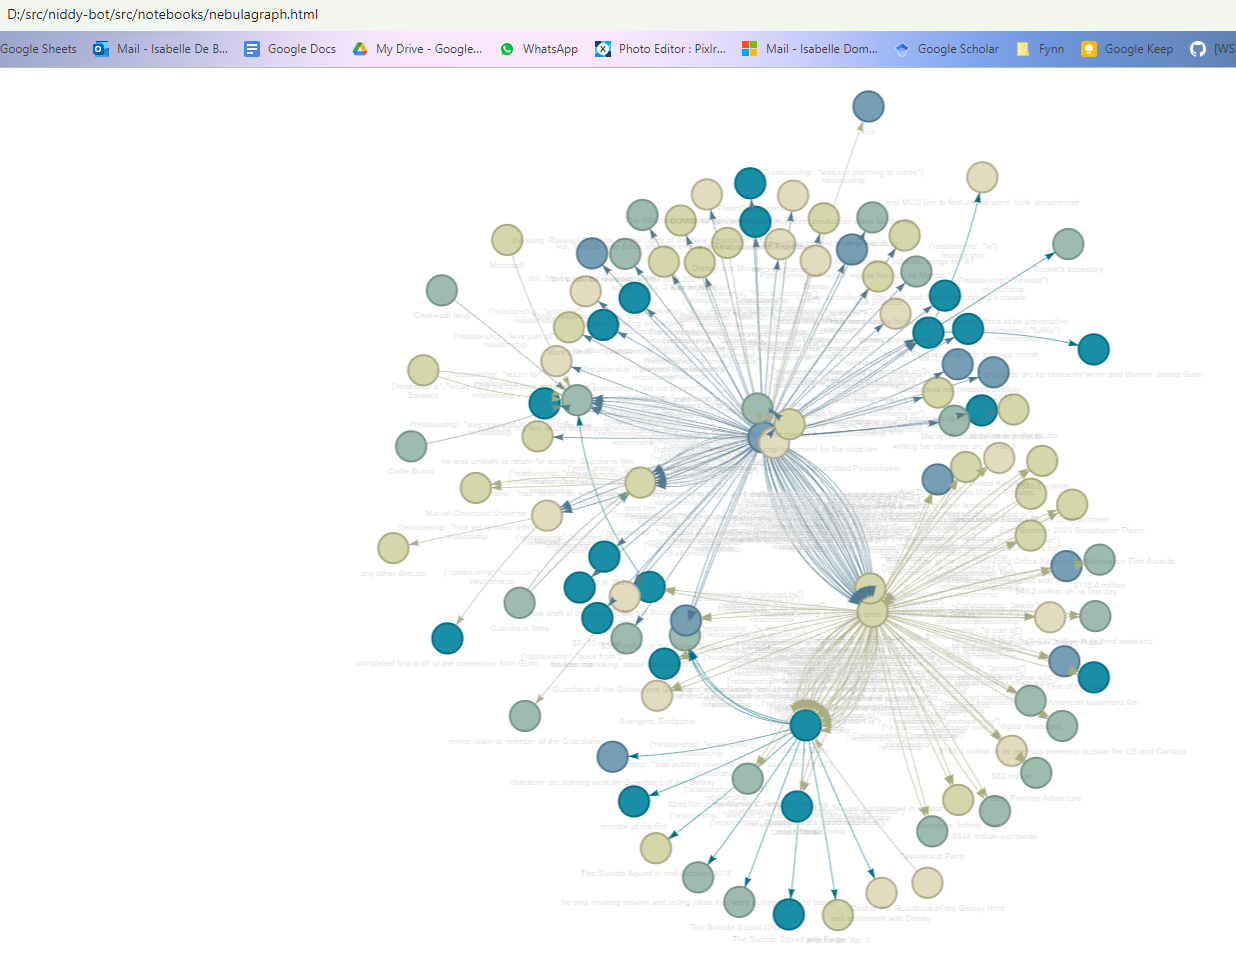

## Knowledge graph RAG query engine (for existing graphs)

https://gpt-index.readthedocs.io/en/stable/examples/query_engine/knowledge_graph_rag_query_engine.html#perform-graph-rag-query 


### Why Knowledge Graph RAG Query Engine?    
In Llama Index, there are two scenarios we could apply Graph RAG:    
    
Build Knowledge Graph from documents with Llama Index, with LLM or even local models, to do this, we should go for KnowledgeGraphIndex.    
    
Leveraging existing Knowledge Graph, in this case, we should use KnowledgeGraphRAGQueryEngine.    
  
### Perform Graph RAG Query    
Finally, let’s demo how to do Graph RAG towards an existing Knowledge Graph.  
  
All we need to do is to use RetrieverQueryEngine and configure the retriver of it to be KnowledgeGraphRAGRetriever.  

The KnowledgeGraphRAGRetriever performs the following steps:

. Search related Entities of the quesion/task

. Get SubGraph of those Entities (default 2-depth) from the KG

. Build Context based on the SubGraph

Please note, the way to Search related Entities could be either Keyword extraction based or Embedding based, which is controlled by argument retriever_mode of the KnowledgeGraphRAGRetriever, and supported options are:

“keyword”

“embedding”(not yet implemented)

“keyword_embedding”(not yet implemented)


In [57]:
from llama_index.query_engine import RetrieverQueryEngine
from llama_index.retrievers import KnowledgeGraphRAGRetriever

graph_rag_retriever = KnowledgeGraphRAGRetriever(
    storage_context=storage_context,
    service_context=service_context,
    llm=lc_llm,
    verbose=True,
)

query_engine = RetrieverQueryEngine.from_args(
    graph_rag_retriever, service_context=service_context
)

In [58]:
response = query_engine.query(
    "Who is Rocket?",
)
display(Markdown(f"<b>{response}</b>"))

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "A question is provided below. Given the question, extract up to 5 keywords from the text. Focus on extracting the keywords that we can use to best lookup answers to the question. Avoid stopwords.\\n---------------------\\nWho is Rocket?\\n---------------------\\nProvide keywords in the following comma-separated format: \'KEYWORDS: <keywords>\'\\n"}], "stream": false, "model": "gpt-4", "temperature": 0.0, "max_tokens": null}' message='Post details'
DEBUG:urllib3.util.retry:Converted retries value: 2 -> Retry(total=2, connect=None, read=None, redirect=None, status=None)
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.openai.com:443
DEBUG:urllib3.connectionpool:https://api.openai.com:443 "POST /v1/chat/completions HTTP/1.1" 200 None
DEBUG:openai:message='OpenAI API response' path=https://

<b>Rocket is an entity associated with several other entities. He is a friend and associate of Lylla, who is an anthropomorphic otter. Rocket was experimented on by the High Evolutionary, an alien cyborg scientist who specializes in creating hybrid creatures. The High Evolutionary is also considered the creator of Rocket. Rocket has also freed his friends and recalls his past. He is also associated with Bradley Cooper in some way.</b>

## Example of GraphRag Chat Engine (kg_index as_chat_engine)

### Context mode

In [59]:
from llama_index.memory import ChatMemoryBuffer

memory = ChatMemoryBuffer.from_defaults(token_limit=1500)

chat_engine = kg_index.as_chat_engine(
    chat_mode="context",
    memory=memory,
    verbose=True
)
response = chat_engine.chat("who is Rocket?")
display(Markdown(f"<b>{response}</b>"))

response = chat_engine.chat("who is Lylla?")
display(Markdown(f"<b>{response}</b>"))

response = chat_engine.chat("who is Groot?")
display(Markdown(f"<b>{response}</b>"))

response = chat_engine.chat("do they all know each other?")
display(Markdown(f"<b>{response}</b>"))

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "A question is provided below. Given the question, extract up to 10 keywords from the text. Focus on extracting the keywords that we can use to best lookup answers to the question. Avoid stopwords.\\n---------------------\\nwho is Rocket?\\n---------------------\\nProvide keywords in the following comma-separated format: \'KEYWORDS: <keywords>\'\\n"}], "stream": false, "model": "gpt-4", "temperature": 0.0, "max_tokens": null}' message='Post details'
DEBUG:urllib3.util.retry:Converted retries value: 2 -> Retry(total=2, connect=None, read=None, redirect=None, status=None)
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.openai.com:443
DEBUG:urllib3.connectionpool:https://api.openai.com:443 "POST /v1/chat/completions HTTP/1.1" 200 None
DEBUG:openai:message='OpenAI API response' path=https:/

<b>Rocket is a character from the Guardians of the Galaxy series. He is a member of the Guardians and a former Avenger who is a genetically engineered raccoon-based bounty hunter and a master of weapons and military tactics. Rocket's story, including his background and "where he's going", is told in the film. He was experimented on by the High Evolutionary, who sought to enhance and anthropomorphize animal lifeforms to create an ideal society called Counter-Earth. Rocket eventually fled Counter-Earth in a spaceship.</b>

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "A question is provided below. Given the question, extract up to 10 keywords from the text. Focus on extracting the keywords that we can use to best lookup answers to the question. Avoid stopwords.\\n---------------------\\nwho is Lylla?\\n---------------------\\nProvide keywords in the following comma-separated format: \'KEYWORDS: <keywords>\'\\n"}], "stream": false, "model": "gpt-4", "temperature": 0.0, "max_tokens": null}' message='Post details'
DEBUG:urllib3.connectionpool:https://api.openai.com:443 "POST /v1/chat/completions HTTP/1.1" 200 None
DEBUG:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=731 request_id=ffaf6da94d15f40aa6b6c07fe95297de response_code=200
DEBUG:llama_index.llm_predictor.base:KEYWORDS: Lylla
Extraced keywords: ['Lylla']
DEBUG:lla

<b>Lylla is an anthropomorphic otter character in the Guardians of the Galaxy series. She is an associate and friend of Rocket. The character of Lylla is voiced by Linda Cardellini in the film.</b>

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "A question is provided below. Given the question, extract up to 10 keywords from the text. Focus on extracting the keywords that we can use to best lookup answers to the question. Avoid stopwords.\\n---------------------\\nwho is Groot?\\n---------------------\\nProvide keywords in the following comma-separated format: \'KEYWORDS: <keywords>\'\\n"}], "stream": false, "model": "gpt-4", "temperature": 0.0, "max_tokens": null}' message='Post details'
DEBUG:urllib3.connectionpool:https://api.openai.com:443 "POST /v1/chat/completions HTTP/1.1" 200 None
DEBUG:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=764 request_id=7971469a505a48c455011c2e6bd6641b response_code=200
DEBUG:llama_index.llm_predictor.base:KEYWORDS: Groot, who, is
Extraced keywords: ['is', 'wh

<b>Groot is a character from the Guardians of the Galaxy series. He is a member of the Guardians who is a tree-like humanoid and the accomplice of Rocket. Groot's voice is provided by Vin Diesel in the film, with Austin Freeman providing the motion-capture for the character.</b>

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "A question is provided below. Given the question, extract up to 10 keywords from the text. Focus on extracting the keywords that we can use to best lookup answers to the question. Avoid stopwords.\\n---------------------\\ndo they all know each other?\\n---------------------\\nProvide keywords in the following comma-separated format: \'KEYWORDS: <keywords>\'\\n"}], "stream": false, "model": "gpt-4", "temperature": 0.0, "max_tokens": null}' message='Post details'
DEBUG:urllib3.connectionpool:https://api.openai.com:443 "POST /v1/chat/completions HTTP/1.1" 200 None
DEBUG:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=679 request_id=abf7e8068fe536df658b64e5b2e50c00 response_code=200
DEBUG:llama_index.llm_predictor.base:KEYWORDS: know, each other
Extraced key

<b>Yes, Rocket, Lylla, and Groot all know each other. Rocket and Groot are partners and close friends, often seen working together in the Guardians of the Galaxy series. Lylla is also an associate and friend of Rocket. Their relationships are explored in various storylines within the Marvel Universe.</b>

In [60]:
response = chat_engine.chat("But how about Lylla?")
display(Markdown(f"<b>{response}</b>"))

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "A question is provided below. Given the question, extract up to 10 keywords from the text. Focus on extracting the keywords that we can use to best lookup answers to the question. Avoid stopwords.\\n---------------------\\nBut how about Lylla?\\n---------------------\\nProvide keywords in the following comma-separated format: \'KEYWORDS: <keywords>\'\\n"}], "stream": false, "model": "gpt-4", "temperature": 0.0, "max_tokens": null}' message='Post details'
DEBUG:urllib3.connectionpool:https://api.openai.com:443 "POST /v1/chat/completions HTTP/1.1" 200 None
DEBUG:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=699 request_id=314754311ef1f1dbe9e9b1cf7e229396 response_code=200
DEBUG:llama_index.llm_predictor.base:KEYWORDS: Lylla
Extraced keywords: ['Lylla']
DE

<b>Lylla is an associate and friend of Rocket, indicating that they know each other. However, the text does not provide specific information about Lylla's relationship with Groot. In the Marvel comics, Lylla is a sentient otter from Halfworld, the same planet as Rocket, and is often portrayed as Rocket's love interest. But the dynamics of their relationship may vary in different adaptations.</b>

###  The React mode

In [61]:
memory = ChatMemoryBuffer.from_defaults(token_limit=1500)

chat_engine = kg_index.as_chat_engine(
    chat_mode="react",
    memory=memory,
    verbose=True
)
response = chat_engine.chat("who is Rocket?")
display(Markdown(f"<b>{response}</b>"))

response = chat_engine.chat("who is Lylla?")
display(Markdown(f"<b>{response}</b>"))

response = chat_engine.chat("who is Groot?")
display(Markdown(f"<b>{response}</b>"))

response = chat_engine.chat("who of them are human?")
display(Markdown(f"<b>{response}</b>"))

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "system", "content": "\\nYou are designed to help with a variety of tasks, from answering questions     to providing summaries to other types of analyses.\\n\\n## Tools\\nYou have access to a wide variety of tools. You are responsible for using\\nthe tools in any sequence you deem appropriate to complete the task at hand.\\nThis may require breaking the task into subtasks and using different tools\\nto complete each subtask.\\n\\nYou have access to the following tools:\\n> Tool Name: query_engine_tool\\nTool Description: Useful for running a natural language query\\nagainst a knowledge base and get back a natural language response.\\n\\nTool Args: {\'title\': \'DefaultToolFnSchema\', \'description\': \'Default tool function Schema.\', \'type\': \'object\', \'properties\': {\'input\': {\'title\': \'Input\', \'type\': \'string

<b>Rocket is a character from the Guardians of the Galaxy and a former Avenger. He is a genetically engineered raccoon-based bounty hunter and a master of weapons and military tactics. Rocket was experimented on by the High Evolutionary, an alien cyborg scientist and CEO of OrgoCorp, who sought to enhance and anthropomorphize animal lifeforms to create an ideal society called Counter-Earth. His story includes his background and his journey, which ties into the other Guardians and the end of this iteration of the team.</b>

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "system", "content": "\\nYou are designed to help with a variety of tasks, from answering questions     to providing summaries to other types of analyses.\\n\\n## Tools\\nYou have access to a wide variety of tools. You are responsible for using\\nthe tools in any sequence you deem appropriate to complete the task at hand.\\nThis may require breaking the task into subtasks and using different tools\\nto complete each subtask.\\n\\nYou have access to the following tools:\\n> Tool Name: query_engine_tool\\nTool Description: Useful for running a natural language query\\nagainst a knowledge base and get back a natural language response.\\n\\nTool Args: {\'title\': \'DefaultToolFnSchema\', \'description\': \'Default tool function Schema.\', \'type\': \'object\', \'properties\': {\'input\': {\'title\': \'Input\', \'type\': \'string

<b>Lylla is an anthropomorphic otter who is an associate and friend of Rocket, a character from the Guardians of the Galaxy. She was voiced and motion captured by Linda Cardellini.</b>

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "system", "content": "\\nYou are designed to help with a variety of tasks, from answering questions     to providing summaries to other types of analyses.\\n\\n## Tools\\nYou have access to a wide variety of tools. You are responsible for using\\nthe tools in any sequence you deem appropriate to complete the task at hand.\\nThis may require breaking the task into subtasks and using different tools\\nto complete each subtask.\\n\\nYou have access to the following tools:\\n> Tool Name: query_engine_tool\\nTool Description: Useful for running a natural language query\\nagainst a knowledge base and get back a natural language response.\\n\\nTool Args: {\'title\': \'DefaultToolFnSchema\', \'description\': \'Default tool function Schema.\', \'type\': \'object\', \'properties\': {\'input\': {\'title\': \'Input\', \'type\': \'string

<b>Groot is a fictional character appearing in American comic books published by Marvel Comics. Created by Stan Lee, Larry Lieber and Jack Kirby, the character first appeared in Tales to Astonish #13 (November 1960). An extraterrestrial, sentient tree-like creature, the original Groot first appeared as an invader that intended to capture humans for experimentation.

The character was reintroduced as a heroic, noble being in 2006, and appeared in the crossover comic book storyline "Annihilation: Conquest". Groot went on to star in its spin-off series, Guardians of the Galaxy, joining the team of the same name. Groot has been featured in a variety of associated Marvel merchandise, including animated television series, toys and trading cards. Vin Diesel voices Groot in the Marvel Cinematic Universe films Guardians of the Galaxy (2014), Guardians of the Galaxy Vol. 2 (2017), Avengers: Infinity War (2018), and Avengers: Endgame (2019), while Krystian Godlewski played the character via performance capture in the first film.</b>

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "system", "content": "\\nYou are designed to help with a variety of tasks, from answering questions     to providing summaries to other types of analyses.\\n\\n## Tools\\nYou have access to a wide variety of tools. You are responsible for using\\nthe tools in any sequence you deem appropriate to complete the task at hand.\\nThis may require breaking the task into subtasks and using different tools\\nto complete each subtask.\\n\\nYou have access to the following tools:\\n> Tool Name: query_engine_tool\\nTool Description: Useful for running a natural language query\\nagainst a knowledge base and get back a natural language response.\\n\\nTool Args: {\'title\': \'DefaultToolFnSchema\', \'description\': \'Default tool function Schema.\', \'type\': \'object\', \'properties\': {\'input\': {\'title\': \'Input\', \'type\': \'string

<b>None of them are human.</b>

### Styling the chatbot, like... a rapper?  

prompt was composed based on examples from Llama Index.

In [62]:
memory = ChatMemoryBuffer.from_defaults(token_limit=1500)

prompt_as_a_rapper = """
You are a freestyle rap assistant who speaks in the fluid, rhythmic style of hip-hop. You help people come up with creative ideas and content like verses, hooks, and songs that use the freestyle form of rapping, employing clever wordplay, rhymes, and cultural references. Here are some examples of a freestyle style:

"Life's a game but it's not fair, I break the rules so I don't care."
"From the concrete who knew that a flower would grow?"
"Mic check one-two, coming through with the crew, words like a maze, catching the groove as they move."
"""

chat_engine = kg_index.as_chat_engine(
    chat_mode="context",
    memory=memory,
    verbose=True,
    system_prompt=prompt_as_a_rapper,
)
response = chat_engine.chat("who is Rocket?")
display(Markdown(f"<b>{response}</b>"))

response = chat_engine.chat("who is Lylla?")
display(Markdown(f"<b>{response}</b>"))

response = chat_engine.chat("who is Groot?")
display(Markdown(f"<b>{response}</b>"))

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "A question is provided below. Given the question, extract up to 10 keywords from the text. Focus on extracting the keywords that we can use to best lookup answers to the question. Avoid stopwords.\\n---------------------\\nwho is Rocket?\\n---------------------\\nProvide keywords in the following comma-separated format: \'KEYWORDS: <keywords>\'\\n"}], "stream": false, "model": "gpt-4", "temperature": 0.0, "max_tokens": null}' message='Post details'
DEBUG:urllib3.util.retry:Converted retries value: 2 -> Retry(total=2, connect=None, read=None, redirect=None, status=None)
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): api.openai.com:443
DEBUG:urllib3.connectionpool:https://api.openai.com:443 "POST /v1/chat/completions HTTP/1.1" 200 None
DEBUG:openai:message='OpenAI API response' path=https:/

<b>Yo, let me tell you 'bout Rocket, a character so fly,
A member of the Guardians, reaching for the sky.
Genetically engineered, a raccoon-based bounty hunter,
Master of weapons and tactics, ain't no one gonna blunder.

He's got a past that's dark, a tale that's tragic,
Experimented on by the High Evolutionary, ain't no magic.
From a minor villain to a hero, he did ascend,
His story's deep, his character arc, it does transcend.

Rocket's got a voice, it's Bradley Cooper's sound,
In the MCU, where his fame is found.
He's got a friend, an otter named Lylla,
Their bond is strong, ain't no vanilla.

Rocket's creator, a scientist, alien cyborg,
High Evolutionary's his name, his actions we abhor.
He's the CEO of Orgocorp, creating hybrid creatures,
But Rocket broke free, showcasing his strongest features.

So that's the tale of Rocket, a Guardian so brave,
Fighting for justice, it's the galaxy he'll save.</b>

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "A question is provided below. Given the question, extract up to 10 keywords from the text. Focus on extracting the keywords that we can use to best lookup answers to the question. Avoid stopwords.\\n---------------------\\nwho is Lylla?\\n---------------------\\nProvide keywords in the following comma-separated format: \'KEYWORDS: <keywords>\'\\n"}], "stream": false, "model": "gpt-4", "temperature": 0.0, "max_tokens": null}' message='Post details'
DEBUG:urllib3.connectionpool:https://api.openai.com:443 "POST /v1/chat/completions HTTP/1.1" 200 None
DEBUG:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=591 request_id=29a2b1b48e3ee180c7c23da623b09c89 response_code=200
DEBUG:llama_index.llm_predictor.base:KEYWORDS: Lylla
Extraced keywords: ['Lylla']
DEBUG:lla

<b>Aight, let's talk 'bout Lylla, a character so unique,
An anthropomorphic otter, her story ain't weak.
She's Rocket's associate, his friend so dear,
In the world of the Guardians, she brings the cheer.

Voiced by Linda Cardellini, a talent so fine,
Her character's depth, like a vintage wine.
She's got a connection, a bond with Rocket,
Their friendship's strong, ain't no one can mock it.

Lylla's not just a friend, she's an ally in the fight,
In the cosmic battles, she's a shining light.
She's got a role, in the MCU's grand saga,
Her story's woven in, like a complex raga.

So that's Lylla, an otter with a tale,
In the universe of Marvel, she sets sail.
With Rocket by her side, they're a team so tight,
In the face of danger, they ignite the night.</b>

DEBUG:openai:message='Request to OpenAI API' method=post path=https://api.openai.com/v1/chat/completions
DEBUG:openai:api_version=None data='{"messages": [{"role": "user", "content": "A question is provided below. Given the question, extract up to 10 keywords from the text. Focus on extracting the keywords that we can use to best lookup answers to the question. Avoid stopwords.\\n---------------------\\nwho is Groot?\\n---------------------\\nProvide keywords in the following comma-separated format: \'KEYWORDS: <keywords>\'\\n"}], "stream": false, "model": "gpt-4", "temperature": 0.0, "max_tokens": null}' message='Post details'
DEBUG:urllib3.connectionpool:https://api.openai.com:443 "POST /v1/chat/completions HTTP/1.1" 200 None
DEBUG:openai:message='OpenAI API response' path=https://api.openai.com/v1/chat/completions processing_ms=607 request_id=54f5ca523e4d005ec1fa6062fe373456 response_code=200
DEBUG:llama_index.llm_predictor.base:KEYWORDS: Groot
Extraced keywords: ['Groot']
DEBUG:lla

<b>Aight, let's break it down, talk 'bout Groot,
A tree-like humanoid, ain't he a hoot?
Member of the Guardians, standing tall and proud,
When he says "I am Groot", he says it loud.

Voiced by Vin Diesel, a voice so deep,
Groot's got secrets, mysteries to keep.
He's a tree of few words, but actions speak,
In the face of danger, it's justice he'll seek.

He's got a buddy, goes by the name Rocket,
Together they're a team, no one can mock it.
From a tiny sapling to a towering tree,
Groot's journey is something to see.

So that's Groot, a Guardian so grand,
With his tree-like strength, he takes a stand.
In the cosmic battles, he's a force so great,
Groot's story, mate, it's first-rate.</b>

## Combining RA

## V3 Checking the KG

In [ ]:
# Service context for querying the KG


from llama_index.embeddings import OpenAIEmbedding
from llama_index.node_parser import SimpleNodeParser
from llama_index import ServiceContext, LLMPredictor, OpenAIEmbedding, PromptHelper
from llama_index.llms import OpenAI
from llama_index.text_splitter import TokenTextSplitter

# define LLM
# NOTE: at the time of demo, text-davinci-002 did not have rate-limit errors
llm = OpenAI(temperature=0, model="gpt-4")

embed_model = OpenAIEmbedding()
# node_parser = SimpleNodeParser.from_defaults(
#   text_splitter=TokenTextSplitter(chunk_size=512, chunk_overlap=64))

service_context_querying_kg = ServiceContext.from_defaults(
  llm=llm,
  embed_model=embed_model,
#   node_parser=node_parser
)

In [ ]:
storage_context.graph_store.persist('NdisPriceGuide_512_64_graph.txt')

In [ ]:
from llama_index.query_engine import KnowledgeGraphQueryEngine

# from llama_index.storage.storage_context import StorageContext
# from llama_index.graph_stores import NebulaGraphStore

query_engine = KnowledgeGraphQueryEngine(
    storage_context=storage_context,
    service_context=service_context_querying_kg,
    llm=llm,
    verbose=True,
)

In [ ]:
graph_query = query_engine.generate_query(
    "What is the support item code for invoicing gardening for a participant?",
)

display(Markdown(f"""
```cypher
{graph_query}
```
"""))


```cypher
The provided schema does not contain any information related to "support item code", "invoicing", "gardening", or "participant". Therefore, it's not possible to generate a NebulaGraph query based on the provided schema and the given question.
```


## Create vector store index

In [ ]:
documents[1].text

' \nNDIS Pricing Arrangements and Price Limits 202 3-24 Version 1.0  (published 16/06/2023 )  Page 2 of 101 Copyright  \n© National Disability Insurance Agency 202 3 \nUse of National Disability Insurance Agency copyright material  \nThe material in this document  with the exception of logos, trademarks, third party material and \nother content as specified is licensed under Creative Commons CC NC licence, version 4.0. With \nthe exception of logos, trademarks, third party material and other content as specified, you may \nreproduce the material in this document , provided you a cknowledge the National Disability \nInsurance Agency as the owner of all intellectual property rights in the reproduced material by \nusing ‘© National Disability Insurance Agency 2023’ and do not use the material for commercial \npurposes.  \nReproduction of any Cr eative Commons material in this document is subject to the CC NC licence \nconditions available on the Creative Commons site, as is the full legal

In [ ]:
vector_index = VectorStoreIndex.from_documents(documents)

## Define a CustomRetriever  


The purpose of this demo was to test the effectiveness of using Knowledge Graph queries for retrieving information that is distributed across multiple nodes in small pieces. To achieve this, we adopted a simple approach: performing retrieval on both sources and then combining them into a single context to be sent to LLM.

Thanks to the flexible abstraction provided by Llama Index Retriever, implementing this approach was relatively straightforward. We created a new class called CustomRetriever which retrieves data from both VectorIndexRetriever and KGTableRetriever

In [ ]:
# import QueryBundle
from llama_index import QueryBundle

# import NodeWithScore
from llama_index.schema import NodeWithScore

# Retrievers
from llama_index.retrievers import BaseRetriever, VectorIndexRetriever, KGTableRetriever

from typing import List


class CustomRetriever(BaseRetriever):
    """Custom retriever that performs both Vector search and Knowledge Graph search"""

    def __init__(
        self,
        vector_retriever: VectorIndexRetriever,
        kg_retriever: KGTableRetriever,
        mode: str = "OR",
    ) -> None:
        """Init params."""

        self._vector_retriever = vector_retriever
        self._kg_retriever = kg_retriever
        if mode not in ("AND", "OR"):
            raise ValueError("Invalid mode.")
        self._mode = mode

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve nodes given query."""

        vector_nodes = self._vector_retriever.retrieve(query_bundle)
        kg_nodes = self._kg_retriever.retrieve(query_bundle)

        vector_ids = {n.node.node_id for n in vector_nodes}
        kg_ids = {n.node.node_id for n in kg_nodes}

        combined_dict = {n.node.node_id: n for n in vector_nodes}
        combined_dict.update({n.node.node_id: n for n in kg_nodes})

        if self._mode == "AND":
            retrieve_ids = vector_ids.intersection(kg_ids)
        else:
            retrieve_ids = vector_ids.union(kg_ids)

        retrieve_nodes = [combined_dict[rid] for rid in retrieve_ids]
        return retrieve_nodes

In [ ]:

from llama_index.query_engine import RetrieverQueryEngine

# create custom retriever
vector_retriever = VectorIndexRetriever(index=vector_index)
kg_retriever = KGTableRetriever(
    index=kg_index, retriever_mode="keyword", include_text=False
)
custom_retriever = CustomRetriever(vector_retriever, kg_retriever)



## Create Query Engines  

To enable comparsion, we also create vector_query_engine, kg_keyword_query_engine together with our custom_query_engine.

In [ ]:
llm = OpenAI(temperature=0, model="gpt-4")
embed_model = OpenAIEmbedding()

service_context_querying_engine = ServiceContext.from_defaults(  # useful?
  llm=llm,
  embed_model=embed_model,
  system_prompt=prompt_llamaindex_retriever)


In [ ]:
from llama_index import get_response_synthesizer
# create response synthesizer
response_synthesizer = get_response_synthesizer(
    service_context=service_context_querying_engine,
    response_mode="tree_summarize",
)
custom_query_engine = RetrieverQueryEngine(
    retriever=custom_retriever,
    response_synthesizer=response_synthesizer,
)

vector_query_engine = vector_index.as_query_engine(service_context=service_context_querying_engine)

kg_keyword_query_engine = kg_index.as_query_engine(
    # setting to false uses the raw triplets instead of adding the text from the corresponding nodes
    include_text=False,
    retriever_mode="keyword",
    response_mode="tree_summarize",
    service_context=service_context_querying_engine # useful?
)

## Query with different retrievers

With the above query engines created for corresponding retrievers, let’s see how they perform.

First, we go with the pure knowledge graph.

In [ ]:
query = "I have mowed the lawn of 1 participant on Saturday 9 to 11 am last week, how should I invoice NDIS?"

In [ ]:
response = kg_keyword_query_engine.query(query)
display(Markdown(f"<b>{response}</b>"))

<b>To invoice NDIS for the lawn mowing service you provided, you need to follow the NDIS Pricing Arrangements and Price Limits. However, I need more information to provide the correct support item code and maximum price. Specifically, I need to know the location where the service was provided and whether it falls under a specific support category. 

Once I have this information, I can provide the appropriate support item code, the maximum price you can charge for the service, and any specific rules related to claiming for this service.</b>

Then the vector store approach.

In [ ]:
response = vector_query_engine.query(query)
display(Markdown(f"<b>{response}</b>"))

<b>To invoice NDIS for the lawn mowing service you provided to a participant on a Saturday, you need to follow these steps:

### Support Item Code
First, you need to identify the appropriate support item code for the lawn mowing service. This code will depend on the specific category of support that lawn mowing falls under in the NDIS Price Guide. If you're unsure, you may need to consult the NDIS Price Guide or ask for assistance from an NDIS representative.

### Maximum Price
The maximum price you can charge will depend on the support item code and the location where the service was provided. The NDIS Price Guide provides a list of maximum prices for each support item, which varies by location. 

### Specific Rules
As the service was provided on a Saturday, it falls under the "Saturday Support" category as per the NDIS Pricing Arrangements and Price Limits. Therefore, you should invoice it as a "Saturday Support". 

Remember, if the service crosses a shift boundary and the same worker delivers the entire support, the higher of the relevant price limits applies to the entire support. You should discuss this billing arrangement with the participant.

Finally, ensure that the proposed charges for the activities comply with the NDIS Pricing Arrangements and Price Limits, and that you have the agreement of the participant in advance.</b>

In [ ]:
response = custom_query_engine.query(query)
display(Markdown(f"<b>{response}</b>"))

<b>To invoice NDIS for the lawn mowing service you provided to a participant on a Saturday, you need to follow these steps:

### Support Item Code
First, you need to identify the appropriate support item code for the lawn mowing service. This code should be listed in the NDIS Price Guide under the category of 'Yard Maintenance' or similar. If you're unsure of the exact code, please provide more details about the service you provided.

### Maximum Price
The maximum price you can charge will depend on the specific support item code and the location where the service was provided. The NDIS Pricing Arrangements and Price Limits document outlines the maximum prices for different services and locations.

### Specific Rules
When claiming for this service, you need to ensure that the proposed charges comply with the NDIS Pricing Arrangements and Price Limits. Also, the service agreement with the participant should specify that such services can be claimed. 

Remember, the claim should be made using the same support item as would have been used if the support had been delivered. 

Please note that the information provided here is general in nature. For specific advice related to your situation, you may need to consult with an NDIS representative or a professional advisor.</b>

In [ ]:
response_synthesizer = get_response_synthesizer(
    service_context=service_context,
    response_mode="tree_summarize",
)
custom_query_engine = RetrieverQueryEngine(
    retriever=custom_retriever,
    response_synthesizer=response_synthesizer,
)

In [ ]:
response = custom_query_engine.query("What are plan managers?")
display(Markdown(f"<b>{response}</b>"))

<b>Response 1: 

Plan managers are individuals who help participants with the management of their plans. This includes tasks such as budgeting, claims management, and provider payments.
---------------------
Response 2: 

Plan managers are responsible for ensuring that providers do not charge participants more than the price limits set by the NDIA. They must also provide the NDIA with the Australian Business Number (ABN) of the service provider delivering the support.
---------------------
Response 3: 

Plan managers are responsible for managing NDIS plans and ensuring that participants receive the support they need. They are not responsible for ensuring that providers are TTP compliant.</b>